<img src="images/Screenshot 2024-05-30 192811.png" style="width:auto; margin:auto; display:block; height:300px"/>


### **LipNet** - A Spatio-Temporal Convolution Based Lip Reading Neural Network for Sentence Level Prediction

<img src="images/Screenshot 2024-05-30 201636.png" style="width:auto; margin:auto; display:block; height:200px"/>

**Changes In Architecture** -
1. Number of Filters and Layers in Spatio-Temporal Convolution.
2. Bidiractional LSTMs instead of GRUs.
3. Number of fully connected layers and nodes.


<a href="https://arxiv.org/pdf/1611.01599">Link to the Actual Paper : LIPNET: END-TO-END SENTENCE-LEVEL LIPREADING<a/>

# 1. Import Dependencies

In [ ]:
%pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import os
import glob
import string

In [3]:
tf.__version__

'2.15.0'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found")

# 2. Data Loading Functions

#### Specification of Loading Video and Preprocessing
* Step 1. Read the video file
* Step 2. Crop the frames in approximate location of the lips
* Step 3. Normalize the frames

In [5]:
def load_video(path : str):
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, np.newaxis])
    cap.release()
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
frames = load_video("/kaggle/input/lip-reading-video-subset/s1/bbaf2n.mpg")
print(frames.shape)

(75, 46, 140, 1)


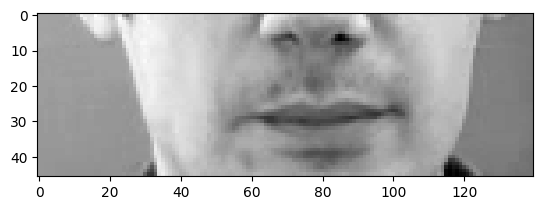

In [8]:
plt.imshow(frames[3], cmap='gray')

### Create Vocabulary and LookUp Table
This lookup table will be used to encode and decoded the characters in labels. This should be consistent over each and every run

In [9]:
vocab = string.ascii_lowercase + "'?! "
vocab = list(vocab)

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [11]:
char2num_dict = {c: char_to_num(c).numpy() for c in char_to_num.get_vocabulary()}
char2num_dict

{'': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27,
 '?': 28,
 '!': 29,
 ' ': 30}

In [12]:
num2char_dict = {char_to_num(c).numpy():c  for c in num_to_char.get_vocabulary()}
num2char_dict

{0: '',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: "'",
 28: '?',
 29: '!',
 30: ' '}

In [13]:
print(char_to_num(["a", "b", "c"]), 
     num_to_char([1,2,3]))

tf.Tensor([1 2 3], shape=(3,), dtype=int64) tf.Tensor([b'a' b'b' b'c'], shape=(3,), dtype=string)


## Specification of Loading Alignments and Preprocessing
* Step 1. Read the text file
* Step 2. Get the text for each word
* Step 3. Create a tensor of numbers from LookUp Table

In [14]:
def load_alignment(path : str):
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        start, end, text = line.split()
        if text!='sil':
            tokens.append(text)
    chars = list(" ".join(tokens))
    return char_to_num(chars)

In [15]:
num = load_alignment("/kaggle/input/lip-reading-video-subset/alignments/s1/bbaf2n.align")
print(num)
print(num_to_char(num))

tf.Tensor([ 2  9 14 30  2 12 21  5 30  1 20 30  6 30 20 23 15 30 14 15 23], shape=(21,), dtype=int64)
tf.Tensor(
[b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'f' b' '
 b't' b'w' b'o' b' ' b'n' b'o' b'w'], shape=(21,), dtype=string)


## Combined Loading Function to Load Video and Alignments at once

In [16]:
def load_data(video_path : str):
    video_id = video_path.numpy().decode('UTF-8').replace("\\", "/").split("/")[-1].split(".")[0]
    align_path = f"/kaggle/input/lip-reading-video-subset/alignments/s1/{video_id}.align"
    video_path = video_path.numpy().decode('UTF-8')
#     print("error 1")
    video_data = load_video(video_path)
#     print("error 2")
    char_num = load_alignment(align_path)
#     print("error 3")
    return video_data, char_num

In [17]:
v,c = load_data(tf.constant("/kaggle/input/lip-reading-video-subset/s1/bbaf3s.mpg"))

In [18]:
v.shape, c.shape

(TensorShape([75, 46, 140, 1]), TensorShape([24]))

In [19]:
def mappable_function(path : str):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 3. Create Data Loading Function

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
videos = glob.glob("/kaggle/input/lip-reading-video-subset/s1/*.mpg")
train, test = train_test_split(videos, test_size=0.2, random_state=42)

In [22]:
data = tf.data.Dataset.from_tensor_slices(train)
data = data.shuffle(500)
data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
data = data.padded_batch(8, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE).cache()

val = tf.data.Dataset.from_tensor_slices(test)
val = val.shuffle(500)
val = val.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
val = val.padded_batch(8, padded_shapes=([75, None, None, None], [40]))
val = val.prefetch(tf.data.AUTOTUNE).cache()

In [23]:
it = data.as_numpy_iterator()

In [24]:
f, a = it.next()
f.shape, a.shape

((8, 75, 46, 140, 1), (8, 40))

# 4. Build Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, Dense, LSTM, Bidirectional, Dropout, 
                                     MaxPool3D, Activation, Reshape, SpatialDropout3D, 
                                     BatchNormalization, TimeDistributed, Flatten, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

#### **Snippet for connecting to Kaggle TPU**

In [26]:
# print("Tensorflow version " + tf.__version__)
# AUTO = tf.data.experimental.AUTOTUNE

# # Detect TPU, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

## **CTC Loss Function [CONNECTIONIST TEMPORAL CLASSIFICATION]**

In [27]:
def CTCLoss(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_true)[0], tf.int64)
    input_len = tf.cast(tf.shape(y_pred)[1], tf.int64)
    label_len = tf.cast(tf.shape(y_true)[1], tf.int64)
    
    input_len = input_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)
    label_len = label_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len) 
    # deprecated, need to find the new method now
    return loss

#### **Snippet for connecting to Kaggle Multiple GPU**

In [28]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

# Define Model for Initial Training

In [29]:
# with strategy.scope():
#     model = Sequential()
#     model.add(Input(shape=(75, 46, 140, 1)))
#     model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPool3D(pool_size=(1,2,2)))

#     model.add(Conv3D(256, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPool3D(pool_size=(1,2,2)))

#     model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPool3D(pool_size=(1,2,2)))

#     model.add(Reshape([75, 5440]))

#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.5))


#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.5))
    
#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.5))
    
#     model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
#     model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
#     model.add(Dense(char_to_num.vocabulary_size()+1, activation='softmax', kernel_initializer='he_normal'))

#     model.summary()
#     model.compile(optimizer=Adam(0.0001), loss=CTCLoss)

# Loading A Checkpoint Model

In [30]:
with strategy.scope():
    model = tf.keras.models.load_model("/kaggle/input/lip-net-custom/tensorflow2/initial-checkpoint-226-epoch/1/model.keras", compile=False)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=CTCLoss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 75, 11, 35, 256)   0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 64)    442432    
                                                        

# 5. Setup Training Module

In [34]:
def schedular(epoch, lr):
    if epoch<50:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [35]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset
        self.it = self.dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        try:
            data = self.it.next()
            if data[0].shape[0]<8:
                self.it = self.dataset.as_numpy_iterator()
                data = self.it.next()
        except Exception as e:
            print(e)
            self.it = self.dataset.as_numpy_iterator()
            data = self.it.next()
        yhat = model.predict(data[0], verbose=0)
        decoded = tf.keras.backend.ctc_decode(yhat, [40]*8, greedy=True)[0][0].numpy()
        for x in range(5):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [36]:
callbacks = [
    ModelCheckpoint("model-226-plus-20.keras", monitor="val_loss", save_best_only=True, verbose=1),
    ModelCheckpoint("model-226-plus-20.h5", monitor="val_loss", save_best_only=True, verbose=1),
    ModelCheckpoint("model-226-plus-20-loss.keras", monitor="loss", save_best_only=True, verbose=1),
    ModelCheckpoint("model-226-plus-20-loss.h5", monitor="loss", save_best_only=True, verbosw=1),
#     LearningRateScheduler(schedular),
    ProduceExample(val),
    ProduceExample(data)

]

In [37]:
model.fit(data, epochs=20, validation_data=(val), callbacks=callbacks, verbose=1)

Epoch 1/20


I0000 00:00:1717068010.704363      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  8/100 [=>............................] - ETA: 9:05 - loss: 11.7999

[mpeg1video @ 0x7c7a6002e280] ac-tex damaged at 22 17
[mpeg1video @ 0x7c7a6002e280] Warning MVs not available


100/100 [==============================] - ETA: 0s - loss: 12.6582 
Epoch 1: val_loss improved from inf to 9.45478, saving model to model-226-plus-20.keras

Epoch 1: val_loss improved from inf to 9.45478, saving model to model-226-plus-20.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: loss improved from inf to 12.65823, saving model to model-226-plus-20-loss.keras
Original: bin green by b two please
Prediction: bin green by p twuo please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in q three again
Prediction: lay blue ith r three again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with z sp two now
Prediction: lay red with h fouro now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at p three again
Prediction: set green in i thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with m nine again
Prediction: lay green with j one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white with f ei

In [38]:
model.save("LipNet-Final-NoCheckpoint.keras")
model.save("LipNet-Final-NoCheckpoint.h5")

In [39]:
callbacks[-1].on_epoch_end(10)

Original: lay blue in j nine again
Prediction: lay blue in d nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at m nine soon
Prediction: bin white in n nine soo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at n five again
Prediction: set blue at m five agai
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in z seven soon
Prediction: bin red in n seven soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with l zero now
Prediction: place green with r zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
